# Multi-Taxi Environment Demonstration
## In the followin example we will demonstrate:
1. Setting up the environment.
2. The different formats of observations.
3. Doc the adjustable parameters.
4. Show how to change the reward table.

In [1]:
# installing easily via pip
!pip install -i https://test.pypi.org/simple/ MultiTaxiLib==0.1.1

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: MultiTaxiLib
    Found existing installation: MultiTaxiLib 0.1.0
    Uninstalling MultiTaxiLib-0.1.0:
      Successfully uninstalled MultiTaxiLib-0.1.0


In [5]:
from MultiTaxiLib.taxi_environment import TaxiEnv
import matplotlib.pyplot as plt

In [6]:
env_instance = TaxiEnv()

### Observations
The observations returned as a dictionary with the keys being "taxi_{i}", such that each item is the observation of agent "i", starting with i=1.

An observation could be either an image, which is a window of sight for the agent, or a sybolic vector consists of: <code>[
            taxi_row, taxi_col, taxi_fuel, 
            passenger1_row, passenger1_col... passenger_n_row, passenger_n_col,
            passenger1_dest_row, passenger1_dest_col... passenger_n_dest_row, passenger_n_dest_col,
            passenger1_status... passenger_n_status
        ]</code>

Symbolic Vector Observation:
[0 4 0 0 0 4 0 2]
Image Observation:


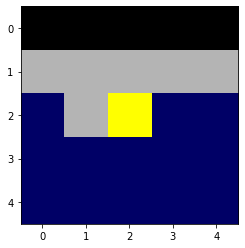

In [7]:
env_instance_image_obs = TaxiEnv(observation_type='image')
env_instance_symbolic_obs = TaxiEnv(observation_type='symbolic')

print(f"Symbolic Vector Observation:\n{env_instance_symbolic_obs.reset()['taxi_1']}")
print("Image Observation:")
plt.imshow(env_instance_image_obs.reset()['taxi_1'])

Note: In image observations, fuel and gas station will have distinct colors (pink and purple), and passengers current locations and destinations will have close colors by values.

### Environment's Parameters
1. <code>num_taxis</code> - the number of taxis operating in the envorinment. _default=1_.
2. <code>num_passengers</code> - the number of passengers to drive in the envorinment. _default=1_.
3. <code>max_fuel</code> - if <code>None</code> - each taxi has unlimited fuel to spent, else, this is the amount of fuel in a full-tank, and this amount decreases by 1 in each timestep unless taxis fill their tank at the station with a special action._default=<code>None</code>_.
4. <code>domain_map</code> - array of chars, representing the environment map with special characters for taxis initilized spots and fuel stations. _default=pre-defined map_.
5. <code>taxis_capacity</code> - a list of integers, where the i'th element represents the i'th taxi's passengers limit, where <code>None</code> represents unlimitted capacity. _default=None_.
6. <code>collision_sensitive_domain</code> - if <code>True</code> - taxis that move to the same grid point in the map - collide and stop their operation, otherwise, there can be multiple taxis at the same grid point. _default=False_.
7. <code>fuel_type_list</code> - a list of either 'F' or 'G', where each element represents the fuel type of each taxi (F for *F*uel and G for *G*as), if <code>None</code> - all are fuel. _default=None_.
8. <code>option_to_stand_by</code> - if <code>True</code> - taxis have the option to take *no_action*. _default=False_.
9. <code>view_len</code> - relevant for image observations, defines the size of the window of sight of the taxis' observations, _default=2_.
10. <code>rewards_table</code> - a dictionary that defines changes in the original reward table, see description below, _default=default_reward_table_.
11. <code>observation_type</code> - either 'symbolic' or 'image', indicating the type of observations to the taxis, _default='symbolic'.

### Changing the Reward Table

The default reward table is:
<code>
    dict(
    step=-1,
    no_fuel=-1,
    bad_pickup=-1,
    bad_dropoff=-1,
    bad_refuel=-1,
    bad_fuel=-1,
    pickup=-1,
    standby_engine_off=-1,
    turn_engine_on=-1,
    turn_engine_off=-1,
    standby_engine_on=-1,
    intermediate_dropoff=2,
    final_dropoff=100,
    hit_wall=-1,
    collision=-1,
    collided=-1,
    unrelated_action=-1,
)</code>

Note that it is intended to be very elaborate. In the default version, the taxis get <code>-1</code> for default actions and "time that goes by", and this apply for many scenarios, s.t bad_pickup, standby, step...

We can use this elaboration in our advantage for customizing this dictionary (or only the parts of it that we would like to change, and then initialize an environment with our reward table of interest.

#### In the next example we'll initialize an environment where we speciall penalize taxis for making <code>bad_pickup</code> tries, all other rewards are the same.

In [5]:
customized_reward = dict(bad_pickup=-50)
env_instance_image_obs = TaxiEnv(rewards_table=customized_reward)

### And just like that! We are good to go!

### After initializing the environemnt you can deploy to it any planner/ RL/ MARL algorithms that you like and works with gym.

# Enjoy!